<a href="https://colab.research.google.com/github/quanho114/Fake-New-Detection/blob/main/Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project**

##**Problem stament :**     

The widespread dissemination of fake news and propaganda presents serious societal risks, including the erosion of public trust, political polarization, manipulation of elections, and the spread of harmful misinformation during crises such as pandemics or conflicts. From an NLP perspective, detecting fake news is fraught with challenges. Linguistically, fake news often mimics the tone and structure of legitimate journalism, making it difficult to distinguish using surface-level features. The absence of reliable and up-to-date labeled datasets, especially across multiple languages and regions, hampers the effectiveness of supervised learning models. Additionally, the dynamic and adversarial nature of misinformation means that malicious actors constantly evolve their language and strategies to bypass detection systems. Cultural context, sarcasm, satire, and implicit bias further complicate automated analysis. Moreover, NLP models risk amplifying biases present in training data, leading to unfair classifications and potential censorship of legitimate content. These challenges underscore the need for cautious, context-aware approaches, as the failure to address them can inadvertently contribute to misinformation, rather than mitigate it.



Use datasets in link : https://drive.google.com/drive/folders/1mrX3vPKhEzxG96OCPpCeh9F8m_QKCM4z?usp=sharing
to complete requirement.

## **About dataset:**

* **True Articles**:

  * **File**: `MisinfoSuperset_TRUE.csv`
  * **Sources**:

    * Reputable media outlets like **Reuters**, **The New York Times**, **The Washington Post**, etc.

* **Fake/Misinformation/Propaganda Articles**:

  * **File**: `MisinfoSuperset_FAKE.csv`
  * **Sources**:

    * **American right-wing extremist websites** (e.g., Redflag Newsdesk, Breitbart, Truth Broadcast Network)
    * **Public dataset** from:

      * Ahmed, H., Traore, I., & Saad, S. (2017): "Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques" *(Springer LNCS 10618)*







# 1. Load Data

In [ ]:
!pip install -qq gdown
!pip install -qq contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.5 MB/s eta 0:00:00


In [ ]:
# Import libraries
import gdown
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import contractions
import warnings
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm
import random

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score

# Transformers libraries
import torch
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    XLNetTokenizer, XLNetForSequenceClassification,
    get_linear_schedule_with_warmup,
    TrainingArguments, Trainer
)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler

# Suppress warnings
warnings.filterwarnings("ignore")

2025-06-07 05:56:47.899722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749275808.071507      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749275808.120756      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Step 1: Download both zip files using gdown
gdown.download(id="1aA9o8PJ-9gYAcLaaxLmXUrxlrHtArlrh", output="file1.zip", quiet=False)
gdown.download(id="1BhaOQU5wYDL8IxOzgvZM-IlgYfJf3HFD", output="file2.zip", quiet=False)

# Step 2: Extract each zip file into separate directories
with zipfile.ZipFile("file1.zip", 'r') as zip_ref:
    zip_ref.extractall("data1")

with zipfile.ZipFile("file2.zip", 'r') as zip_ref:
    zip_ref.extractall("data2")

# Step 3: List the files in each extracted directory
print("Files in data1:")
for root, dirs, files in os.walk("data1"):
    for file in files:
        print(os.path.join(root, file))

print("\nFiles in data2:")
for root, dirs, files in os.walk("data2"):
    for file in files:
        print(os.path.join(root, file))

Downloading...
From (original): https://drive.google.com/uc?id=1aA9o8PJ-9gYAcLaaxLmXUrxlrHtArlrh
From (redirected): https://drive.google.com/uc?id=1aA9o8PJ-9gYAcLaaxLmXUrxlrHtArlrh&confirm=t&uuid=e7ce5ffe-d071-4472-a6e5-9e41fef6dacc
To: /kaggle/working/file1.zip
100%|██████████| 45.1M/45.1M [00:00<00:00, 53.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1BhaOQU5wYDL8IxOzgvZM-IlgYfJf3HFD
From (redirected): https://drive.google.com/uc?id=1BhaOQU5wYDL8IxOzgvZM-IlgYfJf3HFD&confirm=t&uuid=a02b4824-5c81-4c64-afa0-e11c0c825b73
To: /kaggle/working/file2.zip
100%|██████████| 43.0M/43.0M [00:00<00:00, 63.8MB/s]


Files in data1:
data1/DataSet_Misinfo_FAKE.csv

Files in data2:
data2/DataSet_Misinfo_TRUE.csv


In [ ]:
true_df = pd.read_csv("data2/DataSet_Misinfo_TRUE.csv")
fake_df = pd.read_csv("data1/DataSet_Misinfo_FAKE.csv")

In [ ]:
true_df.head()

,Unnamed: 0,text
0,0,The head of a conservative Republican faction ...
1,1,Transgender people will be allowed for the fir...
2,2,The special counsel investigation of links bet...
3,3,Trump campaign adviser George Papadopoulos tol...
4,4,President Donald Trump called on the U.S. Post...


In [ ]:
fake_df.head()

,Unnamed: 0,text
0,0,Donald Trump just couldn t wish all Americans ...
1,1,House Intelligence Committee Chairman Devin Nu...
2,2,"On Friday, it was revealed that former Milwauk..."
3,3,"On Christmas day, Donald Trump announced that ..."
4,4,Pope Francis used his annual Christmas Day mes...


# 2. Data Processing

In [ ]:
# Add labels and combine datasets
true_df['class'] = 1  # True news
fake_df['class'] = 0  # Fake news
df = pd.concat([true_df, fake_df], ignore_index=True)

In [ ]:
# Remove unnecessary columns
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns="Unnamed: 0")

print(f"Combined dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Combined dataset shape: (78617, 2)
Columns: ['text', 'class']


In [ ]:
df.isnull().sum()

text     29
class     0
dtype: int64

In [ ]:
df = df.dropna(subset=['text'])

In [ ]:
# Remove duplicates
initial_size = len(df)
df.drop_duplicates(inplace=True)
print(f"Duplicates removed: {initial_size - len(df)}")
print(f"Final dataset size: {len(df)}")

Duplicates removed: 9984
Final dataset size: 68604


Random Shuffling the dataframe

In [ ]:
df = df.sample(frac = 1)

In [ ]:
df.head()

,text,class
59327,Teens walk free after gang-rape conviction Jud...,0
9830,Republican presidential candidate Donald Trump...,1
59827,"By Gordon Duff, Senior Editor on October 30, 2...",0
8657,President Barack Obama on Friday signed into l...,1
4013,United Nations Secretary-General Antonio Guter...,1


In [ ]:
df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)

In [ ]:
def clean_text_for_transformers(text):
    # Return empty string if input is not valid text
    if not isinstance(text, str) or text.strip() == "":
        return ""
    try:
        # Expand contractions: e.g., "can't" → "cannot", "it's" → "it is"
        text = contractions.fix(text)
    except:
        pass  # Skip if contraction expansion fails

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", " url ", text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphabetic characters (punctuation, symbols, etc.)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    # Convert to lowercase and remove extra whitespace
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Apply text cleaning
print("Cleaning text data...")
tqdm.pandas(desc="Cleaning text")
df['text_clean'] = df['text'].progress_apply(clean_text_for_transformers)

Cleaning text data...


Cleaning text: 100%|██████████| 68604/68604 [00:27<00:00, 2478.95it/s]


In [ ]:
# Remove empty texts after cleaning
df = df[df['text_clean'].str.len() > 0]
print(f"Dataset size after preprocessing: {len(df)}")

Dataset size after preprocessing: 68560


In [ ]:
# Add text statistics
df['text_length'] = df['text_clean'].apply(len)
df['word_count'] = df['text_clean'].apply(lambda x: len(x.split()))

print(f"Average text length: {df['text_length'].mean():.0f} characters")
print(f"Average word count: {df['word_count'].mean():.0f} words")
print(f"Text length range: {df['text_length'].min()} - {df['text_length'].max()} characters")

Average text length: 2799 characters
Average word count: 484 words
Text length range: 1 - 129156 characters


In [ ]:
df.head()

,text,class,text_clean,text_length,word_count
0,Teens walk free after gang-rape conviction Jud...,0,teens walk free after gang rape conviction jud...,879,154
1,Republican presidential candidate Donald Trump...,1,republican presidential candidate donald trump...,2491,417
2,"By Gordon Duff, Senior Editor on October 30, 2...",0,by gordon duff senior editor on october consti...,14935,2493
3,President Barack Obama on Friday signed into l...,1,president barack obama on friday signed into l...,4086,664
4,United Nations Secretary-General Antonio Guter...,1,united nations secretary general antonio guter...,395,64


# 3. Exploratory Data Analysis (EDA)

## 3.1 Class Distribution

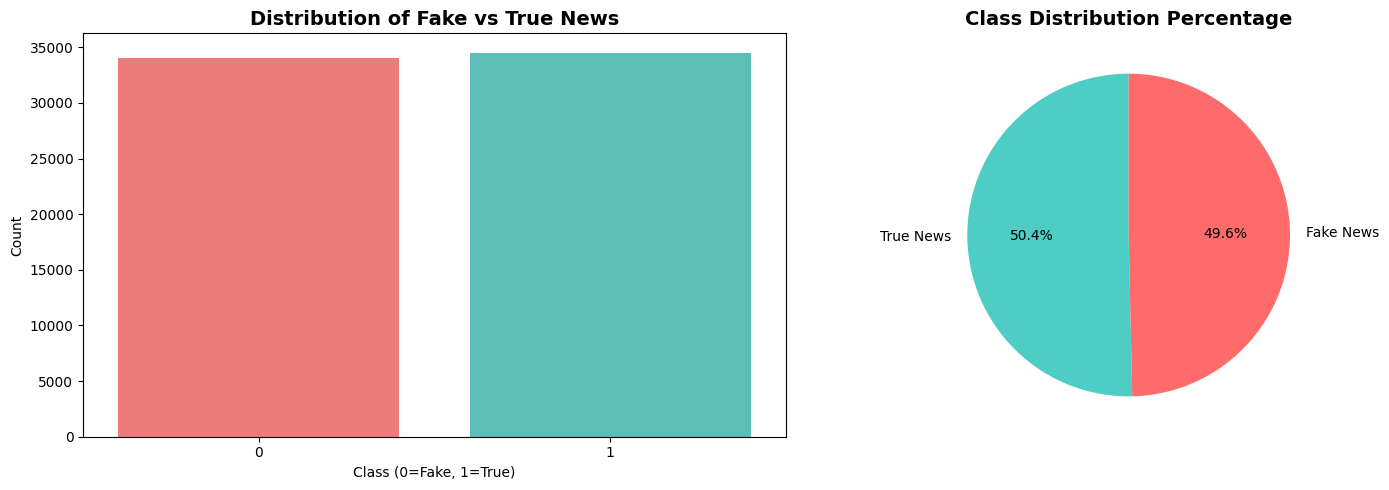

Class distribution:
class
1    34526
0    34034
Name: count, dtype: int64
Class balance ratio: 0.986


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
sns.countplot(data=df, x='class', ax=axes[0], palette=['#FF6B6B', '#4ECDC4'])
axes[0].set_title('Distribution of Fake vs True News', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Fake, 1=True)')
axes[0].set_ylabel('Count')

# Pie chart
class_counts = df['class'].value_counts()
labels = ['True News', 'Fake News']
colors = ['#4ECDC4', '#FF6B6B']
axes[1].pie(class_counts.values, labels=labels, autopct='%1.1f%%',
           colors=colors, startangle=90)
axes[1].set_title('Class Distribution Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print class statistics
print("Class distribution:")
print(df['class'].value_counts())
print(f"Class balance ratio: {df['class'].value_counts().min() / df['class'].value_counts().max():.3f}")

## 3.2 Text Length Analysis

In [ ]:
df['text_length'] = df['text'].astype(str).apply(lambda x: len(x.split()))

df['char_count'] = df['text'].astype(str).apply(len)

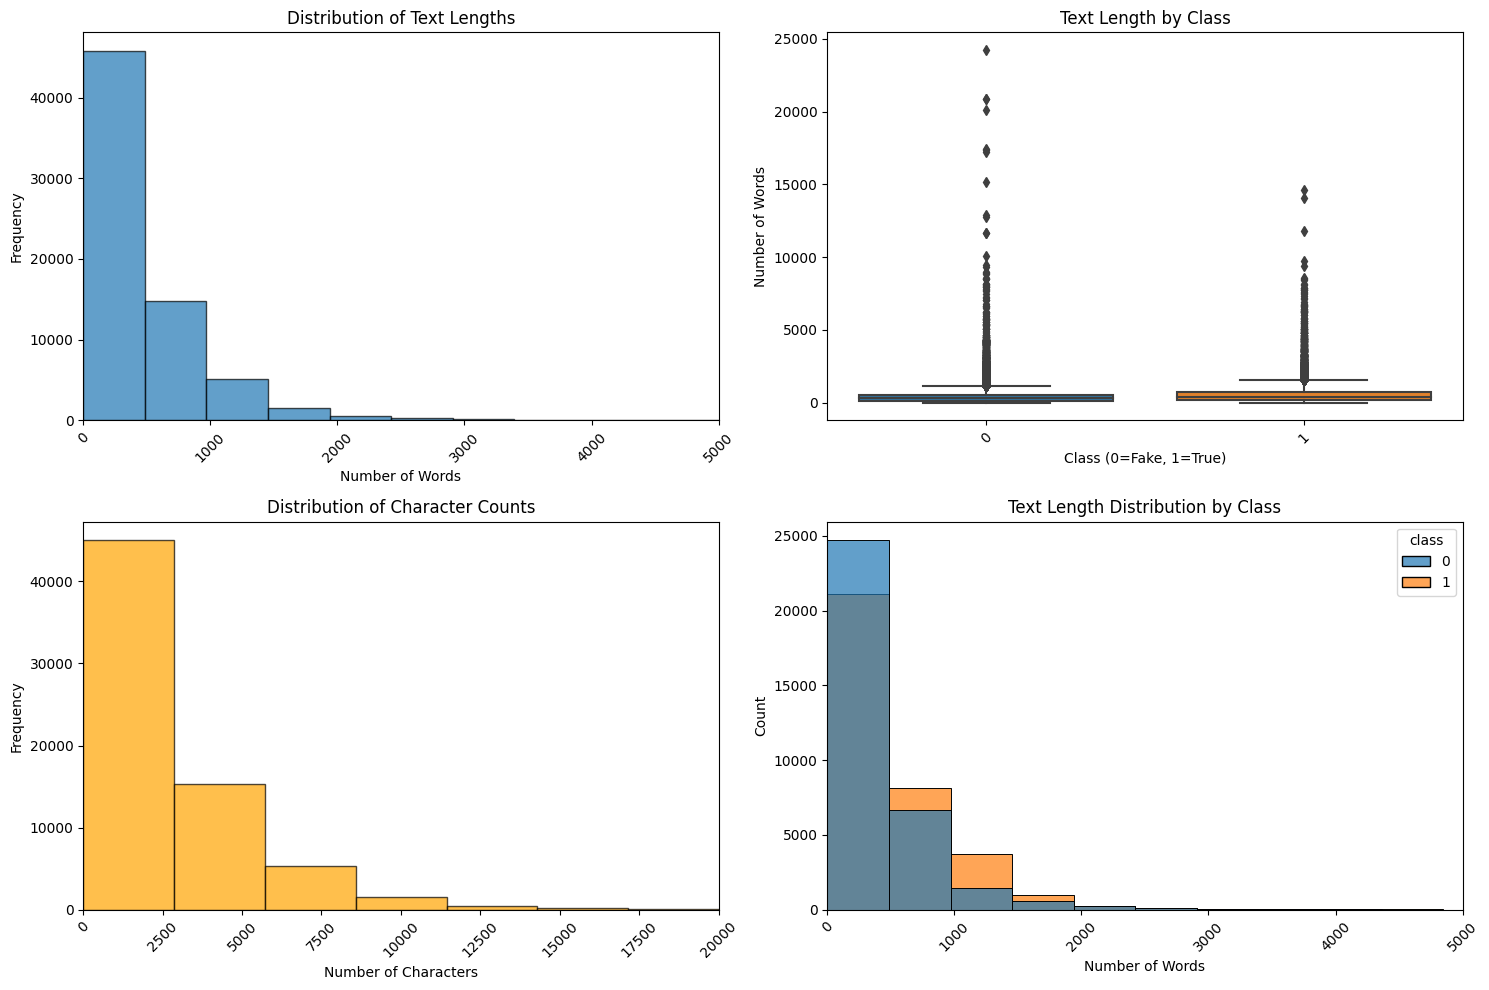


Text length statistics:
         count        mean         std  min    25%    50%     75%      max
class                                                                     
0      34034.0  426.777957  625.650201  1.0   97.0  331.0  509.00  24234.0
1      34526.0  537.157302  567.222748  1.0  181.0  391.0  724.75  14641.0


In [ ]:
# Create 2x2 subplot grid with specified figure size
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot histogram of text length distribution
axes[0,0].hist(df['text_length'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribution of Text Lengths')
axes[0,0].set_xlabel('Number of Words')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_xlim(0, 5000)

# Plot boxplot of text length grouped by class (fake/true)
sns.boxplot(data=df, x='class', y='text_length', ax=axes[0,1])
axes[0,1].set_title('Text Length by Class')
axes[0,1].set_xlabel('Class (0=Fake, 1=True)')
axes[0,1].set_ylabel('Number of Words')
# axes[0,1].set_xlim(0, 5000)

# Plot histogram of character count distribution
axes[1,0].hist(df['char_count'], bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1,0].set_title('Distribution of Character Counts')
axes[1,0].set_xlabel('Number of Characters')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_xlim(0, 20000)

# Plot histogram of text length distribution by class with hue
sns.histplot(data=df, x='text_length', hue='class', bins=50,
             alpha=0.7, ax=axes[1,1])
axes[1,1].set_title('Text Length Distribution by Class')
axes[1,1].set_xlabel('Number of Words')
axes[1,1].set_xlim(0, 5000)

# Rotate x-axis labels for better readability
for ax in axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Print descriptive statistics of text length grouped by class
print("\nText length statistics:")
print(df.groupby('class')['text_length'].describe())

##  3.3 Word Cloud Analysis


Generating word clouds...


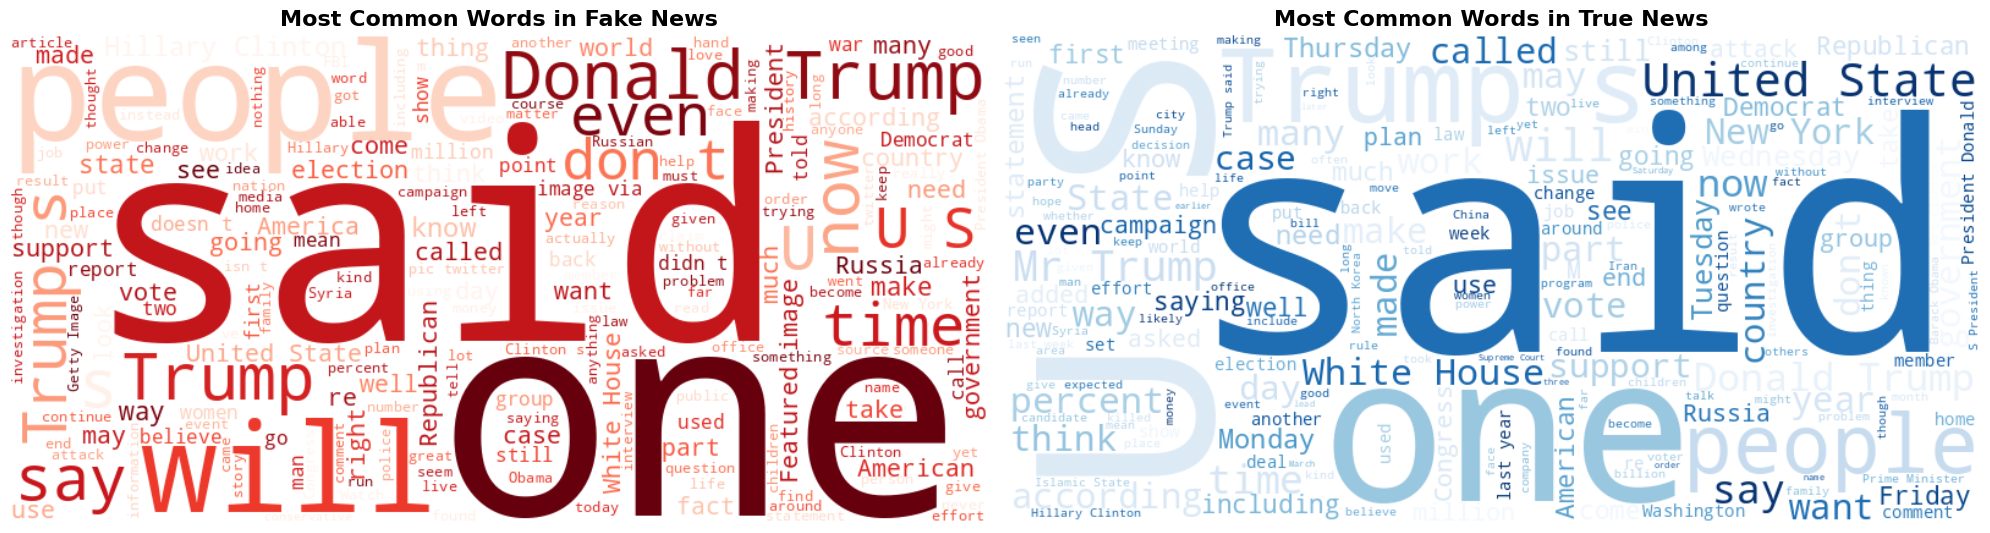

In [ ]:
print("\nGenerating word clouds...")

# Combine text by class
fake_text = ' '.join(df[df['class'] == 0]['text'])
true_text = ' '.join(df[df['class'] == 1]['text'])

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Fake news word cloud
wordcloud_fake = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='Reds').generate(fake_text)
axes[0].imshow(wordcloud_fake, interpolation='bilinear')
axes[0].set_title('Most Common Words in Fake News', fontsize=16, fontweight='bold')
axes[0].axis('off')

# True news word cloud
wordcloud_true = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='Blues').generate(true_text)
axes[1].imshow(wordcloud_true, interpolation='bilinear')
axes[1].set_title('Most Common Words in True News', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

##  3.4 Most Common Words Analysis

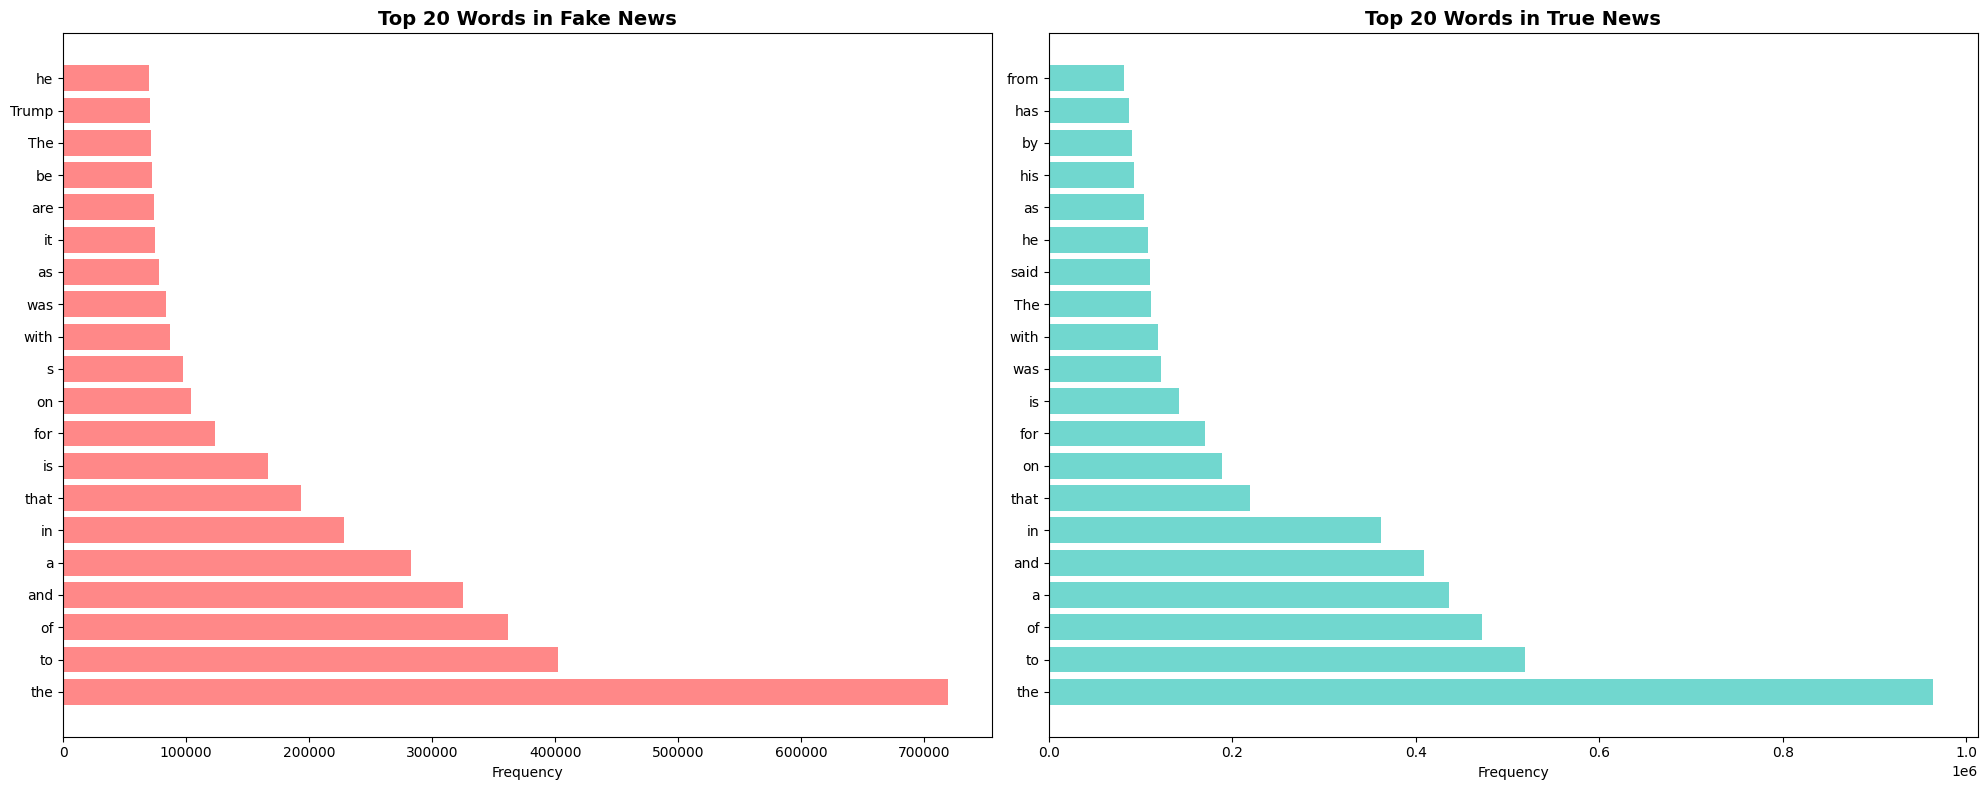

In [ ]:
def get_top_words(text_series, n=20):
    """Get top n words from text series"""
    all_words = ' '.join(text_series).split()
    return Counter(all_words).most_common(n)

# Top words in fake and true news
fake_top_words = get_top_words(df[df['class'] == 0]['text'])
true_top_words = get_top_words(df[df['class'] == 1]['text'])

# Plot top words
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Fake news top words
words, counts = zip(*fake_top_words)
axes[0].barh(range(len(words)), counts, color='#FF6B6B', alpha=0.8)
axes[0].set_yticks(range(len(words)))
axes[0].set_yticklabels(words)
axes[0].set_title('Top 20 Words in Fake News', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency')

# True news top words
words, counts = zip(*true_top_words)
axes[1].barh(range(len(words)), counts, color='#4ECDC4', alpha=0.8)
axes[1].set_yticks(range(len(words)))
axes[1].set_yticklabels(words)
axes[1].set_title('Top 20 Words in True News', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

# 4. Model Building

In [ ]:
# Prepare features and labels
X = df['text_clean'].values
y = df['class'].values

In [ ]:
# Split: 70% Train, 15% Validation, 15% Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [ ]:
print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")

Training set: 47,992 samples (70.0%)
Validation set: 10,284 samples (15.0%)
Test set: 10,284 samples (15.0%)


In [ ]:
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
val_df = pd.DataFrame({'text': X_val, 'label': y_val})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

train_df['encoded_label'] = train_df['label']
val_df['encoded_label'] = val_df['label']
test_df['encoded_label'] = test_df['label']

print("\nLabel values:")
print(sorted(train_df['label'].unique()))


Label values:
[0, 1]


In [ ]:
num_classes = len(train_df['encoded_label'].unique())
print(f"Number of sentiment classes: {num_classes}")

Number of sentiment classes: 2


In [ ]:
bert_model_name = "bert-base-cased"
xlnet_model_name = "xlnet-base-cased"

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model_name)

In [ ]:
# Define maximum sequence length
MAX_LEN = 128

class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding.get('token_type_ids', torch.zeros(self.max_len, dtype=torch.long)).squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
def create_data_loaders(tokenizer, batch_size=16):
    """
    Create PyTorch DataLoaders for training, validation, and test datasets.

    Args:
        tokenizer: Pretrained tokenizer to encode the texts.
        batch_size: Number of samples per batch.

    Returns:
        train_dataloader, val_dataloader, test_dataloader: DataLoader objects
    """
    # Create custom datasets for train, validation, and test sets
    train_dataset = FakeNewsDataset(
        texts=train_df['text'].values,
        labels=train_df['encoded_label'].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )

    val_dataset = FakeNewsDataset(
        texts=val_df['text'].values,
        labels=val_df['encoded_label'].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )

    test_dataset = FakeNewsDataset(
        texts=test_df['text'].values,
        labels=test_df['encoded_label'].values,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )

    # Training sampler and DataLoader - shuffles data at each epoch
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset,
        sampler=train_sampler,
        batch_size=batch_size,
        num_workers=4  # Optional: speed up data loading with multiple workers
    )

    # Validation sampler and DataLoader - no shuffling, deterministic order
    val_sampler = SequentialSampler(val_dataset)
    val_dataloader = DataLoader(
        val_dataset,
        sampler=val_sampler,
        batch_size=batch_size,
        num_workers=4
    )

    # Test sampler and DataLoader - no shuffling
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(
        test_dataset,
        sampler=test_sampler,
        batch_size=batch_size,
        num_workers=4
    )

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
# Set batch size
batch_size = 32

# Create data loaders for BERT and XLNet
bert_train_dataloader, bert_val_dataloader, bert_test_dataloader = create_data_loaders(
    bert_tokenizer, batch_size=batch_size
)

xlnet_train_dataloader, xlnet_val_dataloader, xlnet_test_dataloader = create_data_loaders(
    xlnet_tokenizer, batch_size=batch_size
)

In [ ]:
# Build BERT Model
print(f"Loading BERT model: {bert_model_name}")
bert_model = AutoModelForSequenceClassification.from_pretrained(
    bert_model_name,
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False
)
bert_model = bert_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading BERT model: bert-base-cased


In [ ]:
# Build XLNet Model
print(f"Loading XLNet model: {xlnet_model_name}")
xlnet_model = XLNetForSequenceClassification.from_pretrained(
    xlnet_model_name,
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False
)
xlnet_model = xlnet_model.to(device)

Loading XLNet model: xlnet-base-cased


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set random seeds for reproducibility
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

In [ ]:
import os
import torch

def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, device, epochs=4, patience=2, model_save_path="best_model.pt"):
    """Train the model with early stopping and save the best model"""
    training_stats = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        print(f"\n{'='*30} Epoch {epoch+1}/{epochs} {'='*30}")

        # Training phase
        print("Training...")
        model.train()

        total_train_loss = 0
        train_steps = 0

        for batch in tqdm(train_dataloader):
            model.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch.get('token_type_ids', None)
            if token_type_ids is not None:
                token_type_ids = token_type_ids.to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                **({'token_type_ids': token_type_ids} if token_type_ids is not None else {})
            )

            loss = outputs.loss
            total_train_loss += loss.item()
            train_steps += 1

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / train_steps
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Validation phase
        print("Validating...")
        model.eval()

        total_val_loss = 0
        val_steps = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(val_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch.get('token_type_ids', None)
            if token_type_ids is not None:
                token_type_ids = token_type_ids.to(device)
            labels = batch['label'].to(device)

            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    **({'token_type_ids': token_type_ids} if token_type_ids is not None else {})
                )

            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()
            val_steps += 1

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            label_ids = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(label_ids)

        avg_val_loss = total_val_loss / val_steps
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        })

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0

            # Save the best model
            print(f"Validation loss improved, saving model to {model_save_path}")
            torch.save(model.state_dict(), model_save_path)
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        # Clear CUDA cache after each epoch to free memory
        torch.cuda.empty_cache()

    # Load the best model weights before returning
    model.load_state_dict(torch.load(model_save_path))
    return training_stats, model


# 5. Hyperparameter set up

In [ ]:
# Set hyperparameters
epochs = 3
learning_rate = 2e-5
epsilon = 1e-8
warmup_steps = 0

In [ ]:
# Setup for BERT
bert_optimizer = AdamW(bert_model.parameters(), lr=learning_rate, eps=epsilon)
bert_total_steps = len(bert_train_dataloader) * epochs
bert_scheduler = get_linear_schedule_with_warmup(
    bert_optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=bert_total_steps
)

In [ ]:
# Setup for XLNet
xlnet_optimizer = AdamW(xlnet_model.parameters(), lr=learning_rate, eps=epsilon)
xlnet_total_steps = len(xlnet_train_dataloader) * epochs
xlnet_scheduler = get_linear_schedule_with_warmup(
    xlnet_optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=xlnet_total_steps
)

# 6. Model Training

In [ ]:
# Train BERT model
print("\nTraining BERT model...")
bert_training_stats, bert_trained_model = train_model(
    bert_model,
    bert_train_dataloader,
    bert_val_dataloader,
    bert_optimizer,
    bert_scheduler,
    device,
    epochs=epochs
)


Training BERT model...

============================== Epoch 1/3 ==============================
Training...


100%|██████████| 1500/1500 [17:28<00:00,  1.43it/s]


Average training loss: 0.1989
Validating...


100%|██████████| 322/322 [01:12<00:00,  4.47it/s]


Validation Loss: 0.1325
Validation Accuracy: 0.9516
Validation loss improved, saving model to best_model.pt

============================== Epoch 2/3 ==============================
Training...


100%|██████████| 1500/1500 [17:26<00:00,  1.43it/s]


Average training loss: 0.0838
Validating...


100%|██████████| 322/322 [01:11<00:00,  4.48it/s]


Validation Loss: 0.1241
Validation Accuracy: 0.9613
Validation loss improved, saving model to best_model.pt

============================== Epoch 3/3 ==============================
Training...


100%|██████████| 1500/1500 [17:28<00:00,  1.43it/s]


Average training loss: 0.0384
Validating...


100%|██████████| 322/322 [01:12<00:00,  4.46it/s]


Validation Loss: 0.1663
Validation Accuracy: 0.9633
No improvement in validation loss for 1 epoch(s)


In [ ]:
torch.save(bert_trained_model.state_dict(), "bert_best_model.pt")

In [ ]:
# Train XLNet model
print("\nTraining XLNet model...")
xlnet_training_stats, xlnet_trained_model = train_model(
    xlnet_model,
    xlnet_train_dataloader,
    xlnet_val_dataloader,
    xlnet_optimizer,
    xlnet_scheduler,
    device,
    epochs=epochs
)


Training XLNet model...

============================== Epoch 1/3 ==============================
Training...


100%|██████████| 1500/1500 [24:22<00:00,  1.03it/s]


Average training loss: 0.0948
Validating...


100%|██████████| 322/322 [02:02<00:00,  2.63it/s]


Validation Loss: 0.1292
Validation Accuracy: 0.9552
Validation loss improved, saving model to best_model.pt

============================== Epoch 2/3 ==============================
Training...


100%|██████████| 1500/1500 [24:21<00:00,  1.03it/s]


Average training loss: 0.0961
Validating...


100%|██████████| 322/322 [02:01<00:00,  2.64it/s]


Validation Loss: 0.1292
Validation Accuracy: 0.9552
No improvement in validation loss for 1 epoch(s)

============================== Epoch 3/3 ==============================
Training...


100%|██████████| 1500/1500 [24:22<00:00,  1.03it/s]


Average training loss: 0.0948
Validating...


100%|██████████| 322/322 [02:01<00:00,  2.64it/s]


Validation Loss: 0.1292
Validation Accuracy: 0.9552
No improvement in validation loss for 2 epoch(s)
Early stopping triggered after 3 epochs


In [ ]:
torch.save(xlnet_trained_model.state_dict(), "xlnet_best_model.pt")

# 7. Performance Evaluation

In [ ]:
def evaluate_model(model, dataloader, device):
    """Evaluate the model on given data"""
    model.eval()

    # Tracking variables
    all_preds = []
    all_labels = []

    # Evaluate without gradient calculations
    for batch in tqdm(dataloader):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

        logits = outputs.logits

        # Get predictions
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(label_ids)

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    return accuracy, all_preds, all_labels

In [ ]:
print("\nEvaluating BERT model on test data...")
bert_test_accuracy, bert_test_preds, bert_test_labels = evaluate_model(
    bert_trained_model,
    bert_test_dataloader,
    device
)

print(f"BERT Test Accuracy: {bert_test_accuracy:.4f}")


Evaluating BERT model on test data...


100%|██████████| 322/322 [01:13<00:00,  4.38it/s]

BERT Test Accuracy: 0.9579


In [ ]:
print("\nEvaluating XLNet model on test data...")
xlnet_test_accuracy, xlnet_test_preds, xlnet_test_labels = evaluate_model(
    xlnet_trained_model,
    xlnet_test_dataloader,
    device
)

print(f"XLNet Test Accuracy: {xlnet_test_accuracy:.4f}")


Evaluating XLNet model on test data...


100%|██████████| 322/322 [02:03<00:00,  2.62it/s]

XLNet Test Accuracy: 0.9559


In [ ]:
class_names = ["Fake", "True"]

print("\nBERT Classification Report:")
print(classification_report(bert_test_labels, bert_test_preds, target_names=class_names))

print("\nXLNet Classification Report:")
print(classification_report(xlnet_test_labels, xlnet_test_preds, target_names=class_names))


BERT Classification Report:
              precision    recall  f1-score   support

        Fake       0.96      0.96      0.96      5105
        True       0.96      0.96      0.96      5179

    accuracy                           0.96     10284
   macro avg       0.96      0.96      0.96     10284
weighted avg       0.96      0.96      0.96     10284


XLNet Classification Report:
              precision    recall  f1-score   support

        Fake       0.94      0.98      0.96      5105
        True       0.97      0.94      0.96      5179

    accuracy                           0.96     10284
   macro avg       0.96      0.96      0.96     10284
weighted avg       0.96      0.96      0.96     10284



In [ ]:
# Create confusion matrices
bert_cm = confusion_matrix(bert_test_labels, bert_test_preds)
xlnet_cm = confusion_matrix(xlnet_test_labels, xlnet_test_preds)

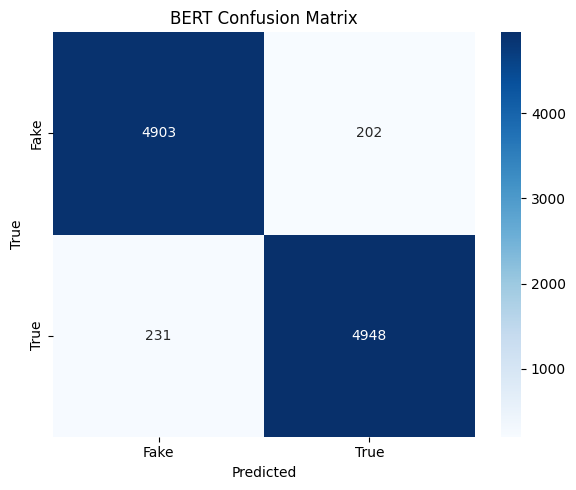

In [ ]:
# Plot BERT confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(bert_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT Confusion Matrix')
plt.tight_layout()
plt.savefig('bert_confusion_matrix.png')

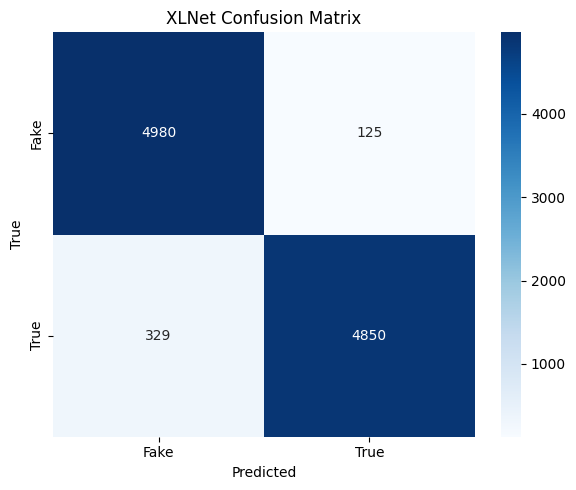

In [ ]:
# Plot XLNet confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(xlnet_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XLNet Confusion Matrix')
plt.tight_layout()
plt.savefig('xlnet_confusion_matrix.png')

## Infer model

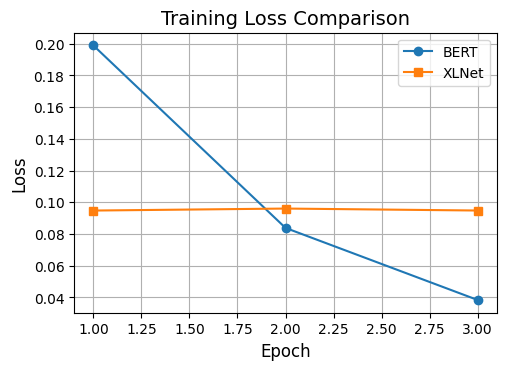

In [ ]:
plt.figure(figsize=(12, 8))

# Training loss
plt.subplot(2, 2, 1)
plt.plot(
    [stat['epoch'] for stat in bert_training_stats],
    [stat['train_loss'] for stat in bert_training_stats],
    color='#1f77b4', marker='o', label='BERT'
)
plt.plot(
    [stat['epoch'] for stat in xlnet_training_stats],
    [stat['train_loss'] for stat in xlnet_training_stats],
    color='#ff7f0e', marker='s', label='XLNet'
)
plt.title('Training Loss Comparison', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

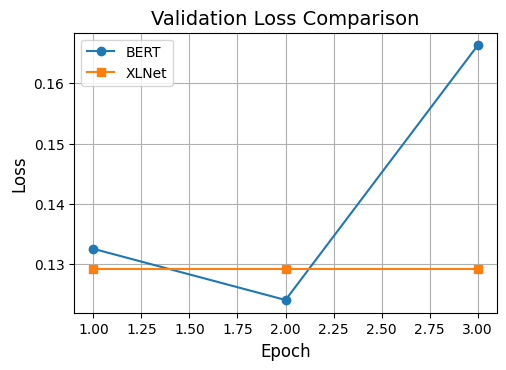

In [ ]:
# Validation loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 2)
plt.plot(
    [stat['epoch'] for stat in bert_training_stats],
    [stat['val_loss'] for stat in bert_training_stats],
    color='#1f77b4', marker='o', label='BERT'
)
plt.plot(
    [stat['epoch'] for stat in xlnet_training_stats],
    [stat['val_loss'] for stat in xlnet_training_stats],
    color='#ff7f0e', marker='s', label='XLNet'
)
plt.title('Validation Loss Comparison', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

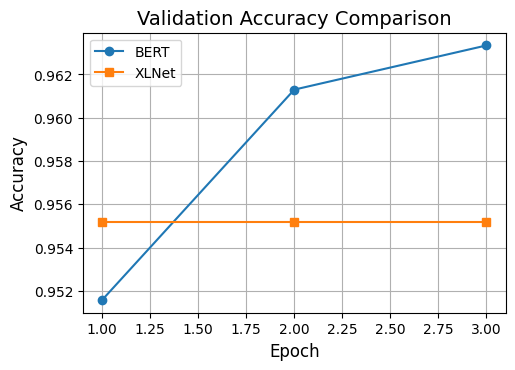

In [ ]:
# Validation accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 3)
plt.plot(
    [stat['epoch'] for stat in bert_training_stats],
    [stat['val_accuracy'] for stat in bert_training_stats],
    color='#1f77b4', marker='o', label='BERT'
)
plt.plot(
    [stat['epoch'] for stat in xlnet_training_stats],
    [stat['val_accuracy'] for stat in xlnet_training_stats],
    color='#ff7f0e', marker='s', label='XLNet'
)
plt.title('Validation Accuracy Comparison', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

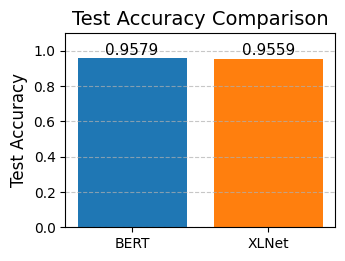

In [ ]:
# Plot test accuracy comparison
plt.subplot(2, 2, 4)
models = ['BERT', 'XLNet']
accuracies = [bert_test_accuracy, xlnet_test_accuracy]

# Màu sắc đẹp, hiện đại
colors = ['#1f77b4', '#ff7f0e']  # xanh ngọc và cam đất

plt.bar(models, accuracies, color=colors)
plt.ylim(0, 1.1)  # Giới hạn trục y để nhìn rõ hơn (nếu accuracy là 0-1)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Test Accuracy Comparison', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=11)

plt.tight_layout()
plt.savefig('model_comparison.png')

In [ ]:
def infer_and_print_random(df, model, tokenizer, device, max_len=128, label_encoder=None, sample_size=5, max_chars=200):
    """
    Randomly select sample_size rows from df,
    predict and print shortened text, predicted label, and true label.
    max_chars: max characters to print from text.
    """
    random_indices = random.sample(range(len(df)), sample_size)
    sample_df = df.iloc[random_indices]

    for idx, row in sample_df.iterrows():
        text = row['text_clean']
        # Shorten text if longer than max_chars
        if len(text) > max_chars:
            display_text = text[:max_chars].rstrip() + '...'
        else:
            display_text = text

        true_label_num = row['class']

        pred_label_text, _ = predict_fake_news(text, model, tokenizer, device, max_len=max_len, label_encoder=label_encoder)

        if label_encoder is not None:
            pred_label_num = label_encoder.transform([pred_label_text])[0]
        else:
            pred_label_num = 1 if pred_label_text == 'Fake' else 0

        print(f"Text: {display_text}")
        print(f"Predicted label: {pred_label_text} ({pred_label_num})")
        print(f"Original label: {'Fake' if true_label_num == 1 else 'Real'} ({true_label_num})")
        print("-" * 80)

In [ ]:
infer_and_print_random(df, bert_trained_model, bert_tokenizer, device, sample_size=5)

Text: the leaders of japan and britain pledged on thursday to cooperate in countering the threat posed by north korea two days after it fired a missile over northern japan north korea s reckless action is a...
Predicted label: Fake (1)
Original label: Fake (1)
--------------------------------------------------------------------------------
Text: chinese importers of foreign publications must verify the products are legal china said on friday weeks after a british academic publisher which blocked access to hundreds of scholarly articles in the...
Predicted label: Fake (1)
Original label: Fake (1)
--------------------------------------------------------------------------------
Text: the media has been talking all day about trump and the republican party s scam of a tax bill as well as the sheer obsequiousness of trump s cabinet and then members of congress after their tax scam wa...
Predicted label: Real (0)
Original label: Real (0)
-------------------------------------------------------

In [ ]:
infer_and_print_random(df, xlnet_trained_model, xlnet_tokenizer, device)

Text: donald trump had a prime opportunity to take advantage of britain s decision to leave the european union in the so called brexit appearing at his golf course in scotland trump held a press conference...
Predicted label: Real (0)
Original label: Real (0)
--------------------------------------------------------------------------------
Text: kenya s repeat presidential poll was free and fair the election commission said on monday despite opposition complaints over the vote that led to it boycotting the process i m satisfied that we were a...
Predicted label: Fake (1)
Original label: Fake (1)
--------------------------------------------------------------------------------
Text: in what was supposed to be a celebration of thanksgiving one little boy named caleb in west virginia was just brought to tears when his teacher ripped away his microphone right before he was about to...
Predicted label: Real (0)
Original label: Real (0)
---------------------------------------------------------

In [ ]:
def predict_fake_news(text, model, tokenizer, device, max_len=128, label_encoder=None):
    """Predict whether a news article is Fake or Real using the trained model"""

    # Tiền xử lý văn bản (nếu có)
    processed_text = clean_text_for_transformers(text)

    # Tokenize văn bản
    encoding = tokenizer.encode_plus(
        processed_text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=True,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Chuyển tensors sang device (CPU/GPU)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    token_type_ids = encoding['token_type_ids'].to(device)

    # Chuyển model sang chế độ evaluation
    model.eval()

    # Dự đoán không tính gradient
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

    # Lấy logits đầu ra
    logits = outputs.logits

    # Chọn lớp có xác suất cao nhất
    pred = torch.argmax(logits, dim=1).cpu().numpy()[0]

    # Chuyển nhãn sang dạng text nếu có label_encoder
    if label_encoder is not None:
        label = label_encoder.inverse_transform([pred])[0]
    else:
        # Nếu không có encoder, giả định 0 = Real, 1 = Fake
        label = "Fake" if pred == 1 else "Real"

    # Tính xác suất dự đoán
    probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()[0]
    confidence = probs[pred]

    return label, confidence

In [ ]:
test_texts = [
    "President Trump signed a new economic relief bill yesterday to support small businesses.",
    "Fake news claims that Trump has secret plans to leave the country after the election.",
    "Trump held a rally attended by thousands of supporters despite the ongoing pandemic.",
    "A viral post falsely states that Trump endorsed a fake cure for COVID-19.",
    "The latest polls show Trump's approval rating increasing steadily over the past month.",
    "Rumors spreading on social media that Trump has been impeached twice this year — this is not true."
]

In [ ]:
print("\nBERT Model Predictions:")
for text in test_texts:
    label, confidence = predict_fake_news(
        text,
        bert_trained_model,
        bert_tokenizer,
        device
    )
    print(f"Text: {text}")
    print(f"Prediction: {label} (Confidence: {confidence:.4f})")
    print("-" * 80)


BERT Model Predictions:
Text: President Trump signed a new economic relief bill yesterday to support small businesses.
Prediction: Real (Confidence: 0.9788)
--------------------------------------------------------------------------------
Text: Fake news claims that Trump has secret plans to leave the country after the election.
Prediction: Real (Confidence: 0.9993)
--------------------------------------------------------------------------------
Text: Trump held a rally attended by thousands of supporters despite the ongoing pandemic.
Prediction: Real (Confidence: 0.9934)
--------------------------------------------------------------------------------
Text: A viral post falsely states that Trump endorsed a fake cure for COVID-19.
Prediction: Real (Confidence: 0.9762)
--------------------------------------------------------------------------------
Text: The latest polls show Trump's approval rating increasing steadily over the past month.
Prediction: Fake (Confidence: 0.8553)
----------

In [ ]:
print("\nXLNet Model Predictions:")
for text in test_texts:
    sentiment, confidence = predict_fake_news(
        text,
        xlnet_trained_model,
        xlnet_tokenizer,
        device
    )
    print(f"Text: {text}")
    print(f"Sentiment: {sentiment} (Confidence: {confidence:.4f})")
    print("-" * 80)


XLNet Model Predictions:
Text: President Trump signed a new economic relief bill yesterday to support small businesses.
Sentiment: Fake (Confidence: 0.8822)
--------------------------------------------------------------------------------
Text: Fake news claims that Trump has secret plans to leave the country after the election.
Sentiment: Real (Confidence: 0.9990)
--------------------------------------------------------------------------------
Text: Trump held a rally attended by thousands of supporters despite the ongoing pandemic.
Sentiment: Real (Confidence: 0.9960)
--------------------------------------------------------------------------------
Text: A viral post falsely states that Trump endorsed a fake cure for COVID-19.
Sentiment: Real (Confidence: 0.9993)
--------------------------------------------------------------------------------
Text: The latest polls show Trump's approval rating increasing steadily over the past month.
Sentiment: Real (Confidence: 0.9669)
--------------